In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator

import time
from IPython.display import clear_output

In [2]:

base_file_path = 'C:/Users/nikoLocal/Documents/Opencampus/Machine_Vision_challenge_data/'
image_path = base_file_path + '/input_train/input_train'

label_csv_name = 'Y_train_eVW9jym.csv'

# load data from csv to pandas dataframe
train_df = pd.read_csv(os.path.join(base_file_path, label_csv_name))

train_df.head()

# Import random Test Dataset

submission_csv_name = 'Y_random_nKwalR1.csv'
submission_image_path = base_file_path + '/input_test_1a4aqAg/input_test'

submission_test_df = pd.read_csv(os.path.join(base_file_path, submission_csv_name))

#ToDo - assign each label a number according to the website so that there is no confusion as to what is what!

#add another column to the dataframe according

dict_numbers = {'GOOD': 0, 'Boucle plate': 1, 'Lift-off blanc': 2, 'Lift-off noir': 3, 'Missing': 4,
                'Short circuit MOS': 5}
dict_strings = {'GOOD': '0_GOOD', 'Boucle plate': '1_Flat loop', 'Lift-off blanc': '2_White lift-off',
                'Lift-off noir': '3_Black lift-off', 'Missing': '4_Missing', 'Short circuit MOS': '5_Short circuit MOS'}

label_list = ['0_GOOD', '1_Flat loop', '2_White lift-off', '3_Black lift-off', '4_Missing', '5_Short circuit MOS']
#label_list.sort()

train_df['LabelNum'] = train_df['Label'].map(dict_numbers)
train_df['LabelStr'] = train_df['Label'].map(dict_strings)

#Process label submission test dataframe

dict_strings_sub = {0: '0_GOOD', 1: '1_Flat loop', 2: '2_White lift-off', 3: '3_Black lift-off', 4: '4_Missing',
                    5: '5_Short circuit MOS', 6: '6_Drift'}

submission_test_df['LabelStr'] = submission_test_df['Label'].map(dict_strings_sub)

submission_test_df.head()

,Unnamed: 0,filename,window,lib,Label,LabelStr
0,0,15669dca9fa601ffded9be0f9cd48097d45e7e05d662b8...,2003,Die01,5,5_Short circuit MOS
1,1,16a9a7106da45758c103a182306d6e2991634e0574edce...,2003,Die01,1,1_Flat loop
2,2,216d84546bb291a840ac2ad0752a828f1f3d64abf79191...,2003,Die01,5,5_Short circuit MOS
3,3,219a89d631e95e19643566512d8bcc45233fe4fe0524c9...,2003,Die01,6,6_Drift
4,4,2a441bba89ae0a867b3ee938063d55538379f8e1298b3c...,2003,Die01,1,1_Flat loop


In [3]:
#Load Baseline model
Trained_baselineModel = tf.keras.models.load_model(os.path.join(base_file_path, 'BaselineCNN_Model.keras'))

In [4]:
# initialize ImageDataGenerators
# use ImageDataGen because it has method flow_from_dataframe() that works really well together with pandas dataframes
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# although deprecated the functionality can be used as discussed in feedback session


# HYPERPARAMTERS ########

target_size = (256,256) #pixel size to load img
class_mode = 'categorical' # how to store labels - either categorical (one-hot encoding) or as numbers
#class_mode = 'input'
batch_size = 8 #later player around with batch size to see how it affects performance
labelCol = 'LabelStr'
#########################

#normalize pixel intensities
rescale = 1.0/255.0

datagen_submission_test = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=0.0)

##########################################################

#generator for submission test data

test_generator_submission = datagen_submission_test.flow_from_dataframe(
    submission_test_df,
    submission_image_path,
    x_col='filename',
    y_col='LabelStr',
    target_size=target_size,
    keep_aspect_ratio = True,
    class_mode=class_mode,
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    seed=42,
    subset='training')

Found 1055 validated image filenames belonging to 7 classes.


In [5]:
label_list_test =  ['0_GOOD','1_Flat loop','2_White lift-off','3_Black lift-off','4_Missing','5_Short circuit MOS','6_Drift']

In [6]:
#make full series of predictions for test data
predicted_labels = Trained_baselineModel.predict(test_generator_submission)
predicted_labels_num = np.argmax(predicted_labels, axis=-1)#convert to numerical - np.argmax directly does the job


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step


In [7]:
predicted_labels_num

array([4, 4, 4, ..., 4, 4, 1], shape=(1055,))

In [8]:
#make dataframe to store processed data
manual_label_df_submission = submission_test_df.copy(deep=True) #deepcopy of the submission data dataframe

manual_label_df_submission['Predicted_Label'] = predicted_labels_num
manual_label_df_submission['Manual_Label'] = 'n.a.'

#save to file
saveName = 'manual_label_df_submission.csv'
SavePath = os.path.join(base_file_path, 'manual_label_df_submission.csv')

if not os.path.exists(SavePath):
    manual_label_df_submission.to_csv(SavePath, index=False)
else:
    #load it instead
    manual_label_df_submission = pd.read_csv(SavePath)


In [9]:
manual_label_df_submission.head()

,Unnamed: 0,filename,window,lib,Label,LabelStr,Predicted_Label,Manual_Label
0,0,15669dca9fa601ffded9be0f9cd48097d45e7e05d662b8...,2003,Die01,5,5_Short circuit MOS,4,4
1,1,16a9a7106da45758c103a182306d6e2991634e0574edce...,2003,Die01,1,1_Flat loop,4,4
2,2,216d84546bb291a840ac2ad0752a828f1f3d64abf79191...,2003,Die01,5,5_Short circuit MOS,4,4
3,3,219a89d631e95e19643566512d8bcc45233fe4fe0524c9...,2003,Die01,6,6_Drift,4,4
4,4,2a441bba89ae0a867b3ee938063d55538379f8e1298b3c...,2003,Die01,1,1_Flat loop,4,4


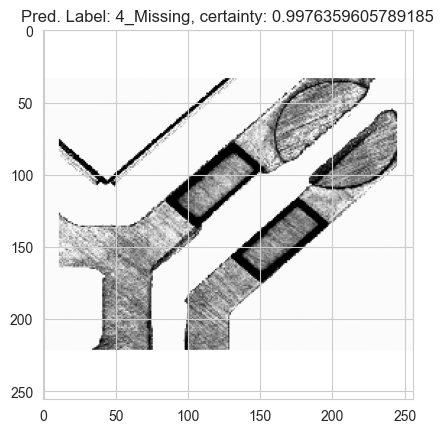

KeyboardInterrupt: Interrupted by user

In [16]:

#import matplotlib
#%matplotlib ipympl
#%matplotlib notebook

import keyboard

i_run_start = 100
stop_index = 150


#    submission_image_path

#need to install package pyqt5
#matplotlib.use('inline')
#plt.ion()
#plt.ioff()

certainty_threshold = 0.7

#important to set the batch index to 0 so that we look at the same data every time!
test_generator_submission.batch_index = i_run_start

i_run = i_run_start
for data in test_generator_submission:

    if i_run >= stop_index:
        print("{} items processed".format(i_run))
        break

    if manual_label_df_submission['Manual_Label'].iloc[i_run] != 'n.a.':
        print('Datapoint already labeled - going to next')
        #move to next data point
        i_run = i_run + 1
    else:
        prediction = Trained_baselineModel.predict(data, verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]

        label_certainty = prediction[0][predicted_label]

        temp_img_generator = np.squeeze(data[0])

        plt.figure()
        plt.imshow(temp_img_generator, cmap='grey')
        plt.title('Pred. Label: {}, certainty: {}'.format(label_list_test[predicted_label],label_certainty))

        plt.pause(0.5)
        #time.sleep(2)

        Input_class = input("Press Enter to continue...")
        #key = keyboard.wait()
        print('Input class: {}'.format(Input_class))

        #check whether label is predicted with high certainty
        #if label_certainty < certainty_threshold:
            #predicted_label = 6

        manual_label_df_submission['Manual_Label'].iloc[i_run] = Input_class

        plt.close()

        #clear output after user input is registered
        clear_output()

        #move to next data point
        i_run = i_run + 1


#save to model when existing loop to not loose progression

manual_label_df_submission.to_csv(SavePath, index=False)


In [12]:
SavePath

'C:/Users/nikoLocal/Documents/Opencampus/Machine_Vision_challenge_data/manual_label_df_submission.csv'